## Загрузка и подготовка данных

In [1]:
# импортируем библиотеки и методы
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
import shap  # package used to calculate Shap values

from catboost import CatBoostClassifier

from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.model_selection import (GridSearchCV, cross_val_score)

from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

# from pandas_profiling import ProfileReport


warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 12345

### Импортируем данные

In [3]:
try:
    data_test = pd.read_csv('yap15-heart-diseases-predictions/test.csv')
    data_train = pd.read_csv('yap15-heart-diseases-predictions/train.csv')
except:
    data_test = 1
    data_train = 1

In [4]:
print(f'Размерность тренировочного датасета = {data_train.shape}\n')
print(f'Размерность тестового датасета = {data_test.shape}\n')


Размерность тренировочного датасета = (70000, 13)

Размерность тестового датасета = (30000, 12)



Изучим информацию о датасете

In [5]:
def initial_acquaintance(df):
    display('Первые 5 строк')
    display(df.head())
    display('5 случайных строк')
    display(df.sample(5))
    display('Информация о датафрейме')
    display(df.info())
    display('Распределение в датафрейме')
    display(df.describe())
    df.hist(bins=30, figsize=(20, 12))
    plt.title('Корреляция признаков')
    plt.figure(figsize=(20, 12))
    sns.heatmap(df.corr(method='spearman'), annot=True, cmap="PuBuGn")
    plt.show()
    print('Количество дубликатов в данных:', df.duplicated().sum())
    print(f'Количество столбцов: {df.shape[1]}, число записей: {df.shape[0]}')


'Информация о данных'

'Первые 5 строк'

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


'5 случайных строк'

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
36254,51773,23327,2,166,60.0,150,90,3,1,0,0,1,1
42810,61163,19910,1,162,59.0,120,80,1,1,0,0,0,0
59007,84229,21014,1,152,70.5,130,90,1,1,0,0,0,0
38442,54887,21290,2,171,101.0,130,85,3,3,0,0,1,1
62787,89656,17796,1,167,69.0,120,70,1,1,0,0,1,1


'Информация о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


None

'Распределение в датафрейме'

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


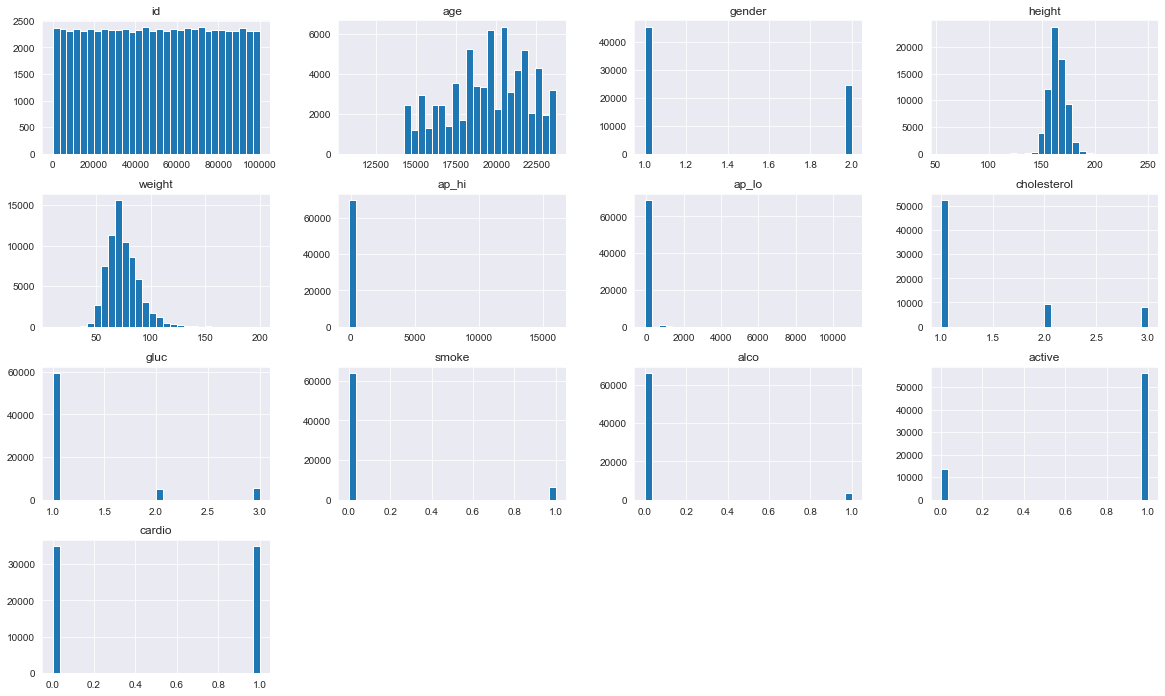

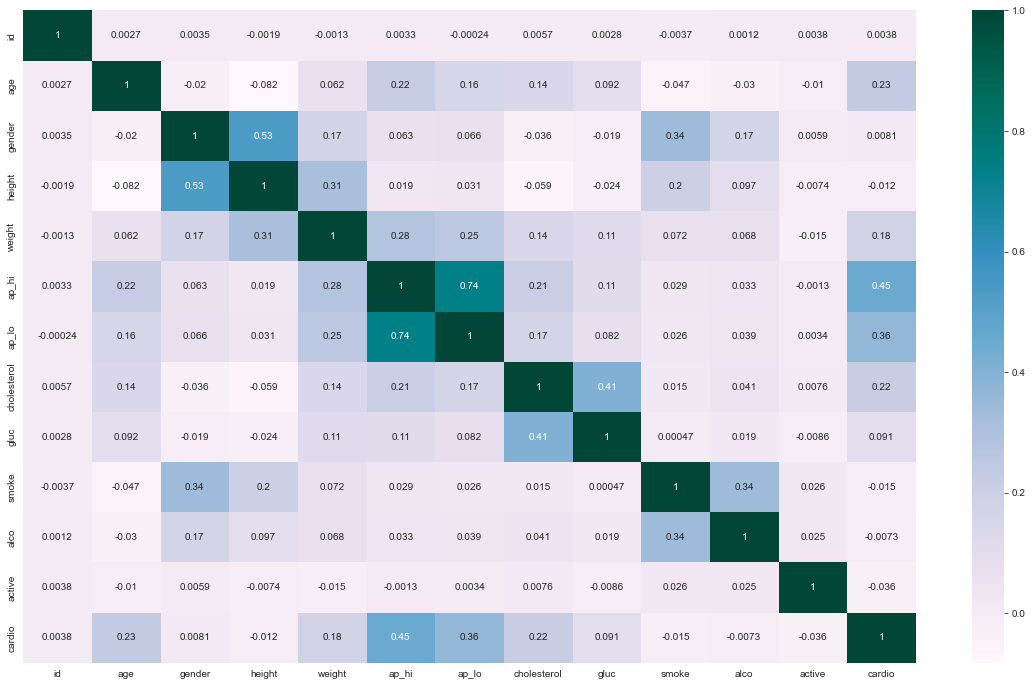

Количество дубликатов в данных: 0
Количество столбцов: 13, число записей: 70000


In [6]:
display('Информация о данных')
initial_acquaintance(data_train)

Признаки
- id — индекс пациента
- age — возраст пациента
- gender — пол пациента
- height — рост пациента, см
- weight — вес пациента, кг
- ap_hi — систолическое давление(верхнее)
- ap_lo — диастолическое давление(нижнее)
- cholesterol — уровень холестерина
- gluc — уровень глюкозы
- smoke — курящий пациент
- alco — отношение к алкоголю у пациента
- active — физическая активность пациента

Целевой признак
- Cardio — risk of heart diseases

In [7]:
data_train_pr = data_train

In [8]:
data_train_pr.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


count    70000.000000
mean       164.359229
std          8.210126
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

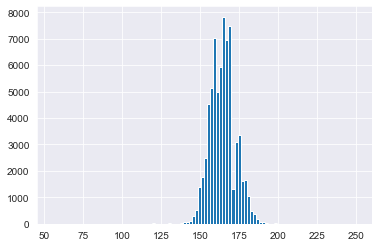

In [9]:
display(data_train_pr.height.describe())
data_train_pr.height.hist(bins=100);

count    70000.000000
mean        74.205690
std         14.395757
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

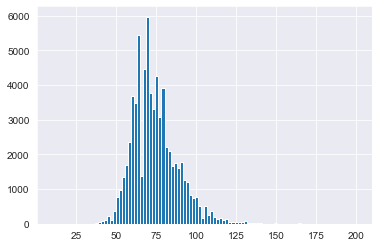

In [10]:
display(data_train_pr.weight.describe())
data_train_pr.weight.hist(bins=100);

count    70000.000000
mean       128.817286
std        154.011419
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

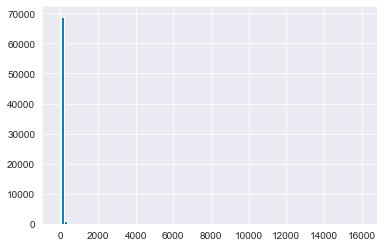

In [11]:
display(data_train_pr.ap_hi.describe())
data_train_pr.ap_hi.hist(bins=100);

count    70000.000000
mean        96.630414
std        188.472530
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64

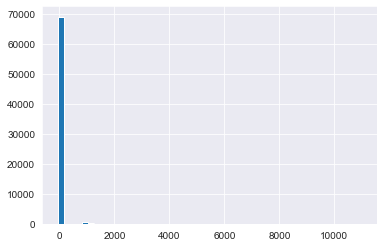

In [12]:
display(data_train_pr.ap_lo.describe())
data_train_pr.ap_lo.hist(bins=50);

In [13]:
round((1 - data_train_pr.shape[0] / data_train.shape[0]) * 100, 4)

0.0

In [14]:
median_height = data_train_pr.height.median()
median_weight = data_train_pr.weight.median()
median_ap_hi = data_train_pr.ap_hi.median()
median_ap_lo = data_train_pr.ap_lo.median()

In [15]:
def preprocessing_dataset (df):
    df = df.drop('id', axis=1)

    df.height.loc[(df.height < 135) | (df.height > 190) ] = median_height

    df.weight.loc[(df.weight < 40) | (df.weight > 140) ] = median_weight

    df.ap_hi.loc[(df.ap_hi <= 10)] = df.ap_hi.loc[(df.ap_hi <= 10)] * 10
    df.ap_hi.loc[(df.ap_hi >= 1000)] = df.ap_hi.loc[(df.ap_hi >= 1000)] / 10
    df.ap_hi.loc[(df.ap_hi < 90) | (df.ap_hi > 190) ] = median_ap_hi

    df.ap_lo.loc[(df.ap_lo <= 10)] = df.ap_lo.loc[(df.ap_lo <= 10)] * 10
    df.ap_lo.loc[(df.ap_lo >= 1000)] = df.ap_lo.loc[(df.ap_lo >= 1000)] / 10
    df.ap_lo.loc[(df.ap_lo < 55) | (df.ap_lo > 112) ] = median_ap_lo

    df['bmi'] = round(df['weight']/(df['height']/100)**2, 3)
    median_bmi = df.bmi.median()
    df.bmi.loc[(df.bmi < 15) | (df.bmi > 43) ] = median_bmi

    df['age'] = df['age'].astype('int64')
    df['gender'] = df['gender'].astype('int64')
    df['ap_hi'] = df['ap_hi'].astype('int64')
    df['ap_lo'] = df['ap_lo'].astype('int64')
    df['cholesterol'] = df['cholesterol'].astype('int64')
    df['gluc'] = df['gluc'].astype('int64')
    df['smoke'] = df['smoke'].astype('int64')
    df['alco'] = df['alco'].astype('int64')
    df['active'] = df['active'].astype('int64')

    df['height'] = df['height'].astype('int64')

    return df

In [16]:
data_train_pr = preprocessing_dataset (data_train_pr)
data_train_pr['cardio'] = data_train_pr['cardio'].astype('int64')
data_train_pr

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.928
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.508
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,2,168,76.0,120,80,1,1,1,0,1,0,26.927
69996,22601,1,158,126.0,140,90,2,2,0,0,1,1,26.370
69997,19066,2,183,105.0,180,90,3,1,0,1,0,1,31.354
69998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27.099


In [17]:
data_train_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
 12  bmi          70000 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 6.9 MB


_______________________________________

In [18]:
# зададим диапазоны гиперпараметров для подбора
param_distributions = {'n_estimators': range(2, 102, 10),
                       'max_depth': range(1, 20, 5),
                       'min_samples_split': range(2, 52, 5),
                       'min_samples_leaf': range(2, 10, 1)}

# подготовим кросс-валидацию на
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [19]:
# отделим обучающий (train) и тестовый (test) датасеты
data_train_ml = data_train_pr
data_test_ml = data_test

# выделим целевой признак
target_train = data_train_ml['cardio']
# создадим признаки для модели
features_train = data_train_ml.drop('cardio', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features_train,
                                                                                          target_train,
                                                                                          test_size=0.25,
                                                                                          random_state=RANDOM_STATE)

# для пайплайна добавим 'RFC__' к названию каждого гиперпараметра
new_params = {'RFC__' + key: param_distributions[key] for key in param_distributions}

# для пайплайна добавим 'GB__' к названию каждого гиперпараметра
new_params_1 = {'GB__' + key: param_distributions[key] for key in param_distributions}

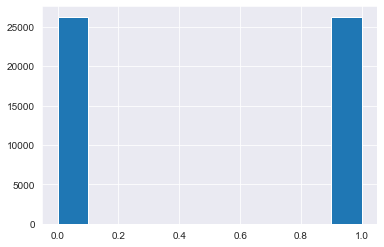

In [20]:
target_train.hist();

In [21]:
target_train.describe()

count    52500.000000
mean         0.499714
std          0.500005
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: cardio, dtype: float64

In [22]:
%%time
# создадим шаги для обработки
# масштабирование и категоризация признаков (FPP - features pre-processing)
step_FPP = ('FPP', ColumnTransformer([
    ('num', make_pipeline(StandardScaler()), make_column_selector(dtype_include=['number']))
]))

step_FPP_RS = ('FPPRS', ColumnTransformer([
    ('num', make_pipeline(
        RobustScaler(
            with_centering=True,
            with_scaling= True,
            quantile_range=(15.0, 85.0),
            copy= True,
            unit_variance=False)),
     make_column_selector(dtype_include=['number']))
]))

# балансировка классов (TPP - target pre-processing)
step_TPP = ('TPP', SMOTE(random_state=RANDOM_STATE))

# классификаторы модели
step_RFC = ('RFC', RandomForestClassifier(random_state=RANDOM_STATE))

step_GB = ('GB', GradientBoostingClassifier(random_state=RANDOM_STATE))

step_CB = ('CB', CatBoostClassifier(random_state=RANDOM_STATE, verbose=False))



CPU times: user 153 µs, sys: 189 µs, total: 342 µs
Wall time: 937 µs


In [23]:
# зададим последовательность обработки RFC
pipeline_RFC = Pipeline(steps=[step_FPP_RS, step_TPP, step_RFC])

# зададим последовательность обработки GB
pipeline_GB = Pipeline(steps=[step_FPP, step_TPP, step_GB])

# зададим последовательность обработки CB
pipeline_CB = Pipeline(steps=[step_FPP_RS, step_CB])

# создадим объект модели RFC
rs_rfc = RandomizedSearchCV(pipeline_RFC, new_params, n_iter=5, cv=kf, verbose=1,
                            n_jobs=-1, scoring='roc_auc', return_train_score=True, random_state=RANDOM_STATE, refit='roc_auc')

# создадим объект модели GB
rs_gb = RandomizedSearchCV(pipeline_GB, new_params_1, n_iter=5, cv=kf, verbose=1,
                           n_jobs=-1, scoring='roc_auc', return_train_score=True, random_state=RANDOM_STATE, refit='roc_auc')

In [24]:
# Define parameters' grid
grid = {'CB__verbose': [False],
        'CB__thread_count': [-1],
        'CB__depth': [3, 4, 5, 7, 9],
        'CB__iterations': [500, 1000, 2000, 3000],
        'CB__learning_rate': [0.0001, 0.001, 0.01]}

# Define GridSearchCV
grid_cat = GridSearchCV(estimator=pipeline_CB, param_grid=grid, cv=5,
                        n_jobs=-1, scoring='roc_auc')

In [25]:
%%time
# обучаем модель RFC
rs_rfc.fit(features_train, target_train)

# выведем значение
print(rs_rfc.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.8007308591955642
CPU times: user 2.75 s, sys: 166 ms, total: 2.92 s
Wall time: 13.5 s


In [26]:
%%time
# обучаем модель GB
rs_gb.fit(features_train, target_train)

# выведем значение
print(rs_gb.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.7926232610833324
CPU times: user 2.27 s, sys: 70.6 ms, total: 2.34 s
Wall time: 24.7 s


In [27]:
%%time

grid_cat.fit(features_train, target_train)

print(grid_cat.best_score_)

params = grid_cat.best_params_

print('\n Best Score:\n', grid_cat.best_score_)
print('\n Best parameters:\n', params)

0.8023620615422604

 Best Score:
 0.8023620615422604

 Best parameters:
 {'CB__depth': 7, 'CB__iterations': 1000, 'CB__learning_rate': 0.01, 'CB__thread_count': -1, 'CB__verbose': False}
CPU times: user 16.7 s, sys: 8.62 s, total: 25.3 s
Wall time: 14min 48s


In [28]:

# получим предсказание модели на тестовой выборке
predicted_test = grid_cat.best_estimator_.predict(features_valid)

# получим оценки вероятности положительного исхода
rf_probs = grid_cat.best_estimator_.predict_proba(features_valid)[:, 1]

# выведем значение ROC-AUC для положительного исхода
print(f'ROC-AUC = {roc_auc_score(target_valid, rf_probs):.4f}')

# выведем значения гиперпараметров модели
display(grid_cat.best_params_)

ROC-AUC = 0.8024


{'CB__depth': 7,
 'CB__iterations': 1000,
 'CB__learning_rate': 0.01,
 'CB__thread_count': -1,
 'CB__verbose': False}

### train a best estimator on full train dataset

In [32]:
target_train = data_train_ml['cardio']
features_train = data_train_ml.drop('cardio', axis=1)

In [33]:
%%time

grid_cat.fit(features_train, target_train)

print(grid_cat.best_score_)

params = grid_cat.best_params_

print('\n Best Score:\n', grid_cat.best_score_)
print('\n Best parameters:\n', params)

0.8024885362500515

 Best Score:
 0.8024885362500515

 Best parameters:
 {'CB__depth': 5, 'CB__iterations': 2000, 'CB__learning_rate': 0.01, 'CB__thread_count': -1, 'CB__verbose': False}
CPU times: user 35.4 s, sys: 15 s, total: 50.4 s
Wall time: 17min 34s


### test dataset preprocessing


In [34]:
data_test_ml = preprocessing_dataset (data_test)
data_test_ml

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
0,18888,1,154,85.0,130,80,1,1,0,0,1,35.841
1,19042,2,170,69.0,130,90,1,1,0,0,1,23.875
2,20432,1,160,70.0,120,75,1,1,0,0,0,27.344
3,18133,2,185,94.0,130,90,1,1,0,0,1,27.465
4,16093,2,170,76.0,120,80,1,1,0,0,1,26.298
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,21722,2,170,103.0,150,90,1,1,0,1,0,35.640
29996,18309,1,172,78.0,110,70,1,1,0,0,1,26.366
29997,21247,2,169,61.0,120,80,1,1,0,0,0,21.358
29998,14509,2,175,80.0,120,80,2,1,0,0,0,26.122


In [35]:
predictions_test = grid_cat.best_estimator_.predict_proba(data_test_ml)

predictions_test

array([[0.49549677, 0.50450323],
       [0.46657763, 0.53342237],
       [0.60047256, 0.39952744],
       ...,
       [0.57105952, 0.42894048],
       [0.68842473, 0.31157527],
       [0.31677057, 0.68322943]])

In [36]:
pred_caggle = data_test
pred_caggle['cardio'] = predictions_test[:,1]
pred_caggle = pred_caggle[['id','cardio']]
pred_caggle.to_csv('pred_kaggle_v3.csv',index=False)